#  Employee’s Performance for HR Analytics (Unsupervised Learning)

**📊 Dataset:** `Uncleaned_employees_final_dataset (1).csv`  
**📚 Source:** [Kaggle – HR Analytics: Employee Performance Dataset](https://www.kaggle.com/)  



### 🎯 Goal
Use **unsupervised learning (clustering)** to discover hidden employee groups based on demographics, performance, and experience.  
This helps HR understand workforce patterns and improve engagement and retention strategies.



### 📈 Description
By analyzing features like:
- `age`, `education`, `department`, `length_of_service`,  
- `no_of_trainings`, `previous_year_rating`, `KPIs_met_more_than_80`,  
- `awards_won`, and `avg_training_score`,  

the project identifies meaningful employee clusters to support **data-driven HR decisions**.


In [45]:
# Phase 0: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sklearn libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# For saving models
import os
import joblib


In [46]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Msi\OneDrive\Documents\ML\Employee-Segmentation-Clustering\Data\Uncleaned_employees_final_dataset (1).csv")

# Phase 1: Data Overview & Understanding

# Data Overview

In [47]:
# Check the number of rows and columns
print("Dataset Shape:", df.shape)

Dataset Shape: (17417, 13)


In [48]:
# Display first 5 rows to understand the structure
display(df.head())

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61


In [49]:
# Display sample 5 rows to understand the structure
display(df.sample(5))

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
17054,51099,Analytics,region_21,Bachelors,m,other,1,44,3.0,2,0,0,85
14983,77106,Operations,region_7,Bachelors,m,other,1,42,3.0,12,1,0,60
16476,20139,Technology,region_19,Bachelors,m,other,1,34,3.0,5,0,0,81
1579,41449,Procurement,region_26,Bachelors,f,sourcing,1,24,NaN,1,0,0,74
14956,73436,Sales & Marketing,region_26,Masters & above,m,sourcing,1,39,5.0,2,0,0,49


In [50]:
# View dataset information (column types and null values)
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17417 entries, 0 to 17416
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employee_id            17417 non-null  int64  
 1   department             17417 non-null  object 
 2   region                 17417 non-null  object 
 3   education              16646 non-null  object 
 4   gender                 17417 non-null  object 
 5   recruitment_channel    17417 non-null  object 
 6   no_of_trainings        17417 non-null  int64  
 7   age                    17417 non-null  int64  
 8   previous_year_rating   16054 non-null  float64
 9   length_of_service      17417 non-null  int64  
 10  KPIs_met_more_than_80  17417 non-null  int64  
 11  awards_won             17417 non-null  int64  
 12  avg_training_score     17417 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.7+ MB


In [51]:
# Summary of numerical features
print("\nNumerical Summary:")
display(df.describe().T)


Numerical Summary:


,count,mean,std,min,25%,50%,75%,max
employee_id,17417.0,39083.491129,22707.024087,3.0,19281.0,39122.0,58838.0,78295.0
no_of_trainings,17417.0,1.250732,0.595692,1.0,1.0,1.0,1.0,9.0
age,17417.0,34.807774,7.694046,20.0,29.0,33.0,39.0,60.0
previous_year_rating,16054.0,3.345459,1.265386,1.0,3.0,3.0,4.0,5.0
length_of_service,17417.0,5.801860,4.175533,1.0,3.0,5.0,7.0,34.0
KPIs_met_more_than_80,17417.0,0.358845,0.479675,0.0,0.0,0.0,1.0,1.0
awards_won,17417.0,0.023368,0.151074,0.0,0.0,0.0,0.0,1.0
avg_training_score,17417.0,63.176322,13.418179,39.0,51.0,60.0,75.0,99.0


In [52]:
# Summary of categorical features
print("\nCategorical Summary:")
display(df.describe(include='object').T)


Categorical Summary:


,count,unique,top,freq
department,17417,9,Sales & Marketing,5458
region,17417,34,region_2,3918
education,16646,3,Bachelors,11519
gender,17417,2,m,12314
recruitment_channel,17417,3,other,9751


# Data Understanding

In [53]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [54]:
print("\nNumerical Columns:", num_cols.tolist())
print("Categorical Columns:", cat_cols.tolist())


Numerical Columns: ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met_more_than_80', 'awards_won', 'avg_training_score']
Categorical Columns: ['department', 'region', 'education', 'gender', 'recruitment_channel']


In [55]:
# Count unique values per column
print("\nUnique Values per Column:")
display(df.nunique().to_frame('Unique Values').T)


Unique Values per Column:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
Unique Values,17414,9,34,3,2,3,9,41,5,34,2,2,61


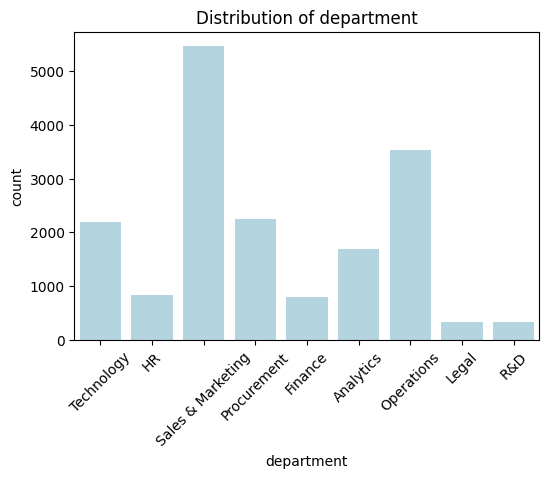

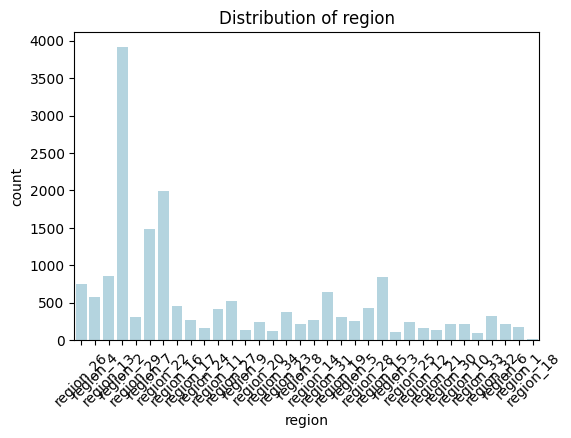

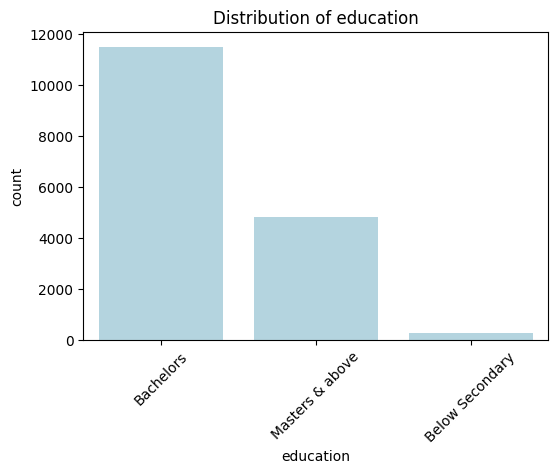

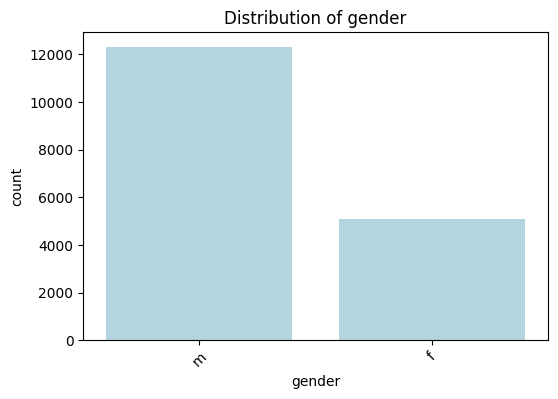

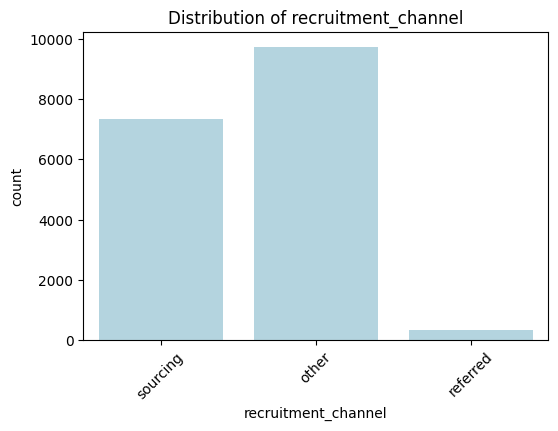

In [56]:
# Visualize first few categorical columns
for col in cat_cols[:5]:  
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, color='lightblue')  
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

In [57]:
# Display the number of numerical and categorical columns
print(f"✅ Total Numerical Columns: {len(num_cols)}")
print(f"✅ Total Categorical Columns: {len(cat_cols)}")

✅ Total Numerical Columns: 8
✅ Total Categorical Columns: 5


#  Phase 2: Data Cleaning

In [58]:
# Check for Missing Values
print("🔹 Missing Values per Column:")
print(df.isnull().sum())

🔹 Missing Values per Column:
employee_id                 0
department                  0
region                      0
education                 771
gender                      0
recruitment_channel         0
no_of_trainings             0
age                         0
previous_year_rating     1363
length_of_service           0
KPIs_met_more_than_80       0
awards_won                  0
avg_training_score          0
dtype: int64


Handle Missing Values

In [59]:
# Fill missing 'education' values with the most frequent category (mode)
df['education'] = df['education'].fillna(df['education'].mode()[0])

In [60]:
# Fill missing 'previous_year_rating' with the median value
df['previous_year_rating'] = df['previous_year_rating'].fillna(df['previous_year_rating'].median())

In [61]:
# Verify that missing values are handled
print("✅ Missing values after filling:")
print(df.isnull().sum())

✅ Missing values after filling:
employee_id              0
department               0
region                   0
education                0
gender                   0
recruitment_channel      0
no_of_trainings          0
age                      0
previous_year_rating     0
length_of_service        0
KPIs_met_more_than_80    0
awards_won               0
avg_training_score       0
dtype: int64


Check for Duplicates

In [62]:
print("\n🔹 Number of duplicate rows:", df.duplicated().sum())


🔹 Number of duplicate rows: 2


 Remove duplicate rows

In [63]:
df.drop_duplicates(inplace=True)

In [64]:
# Confirm removal
print("✅ Duplicates removed successfully!")
print("🔹 New dataset shape:", df.shape)

✅ Duplicates removed successfully!
🔹 New dataset shape: (17415, 13)


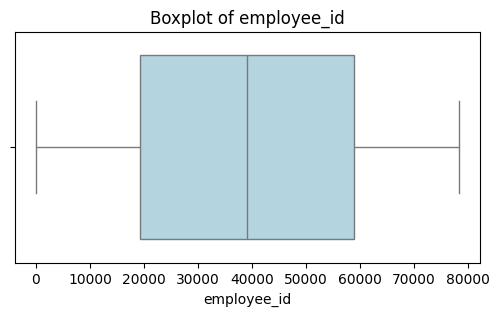

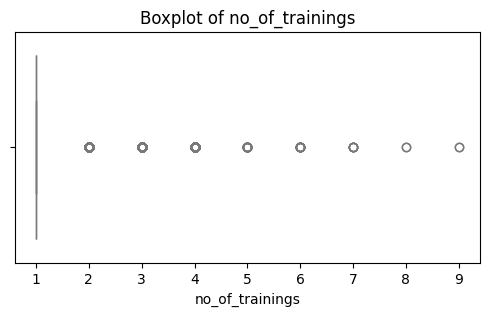

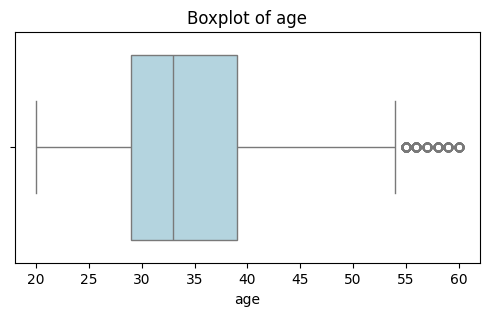

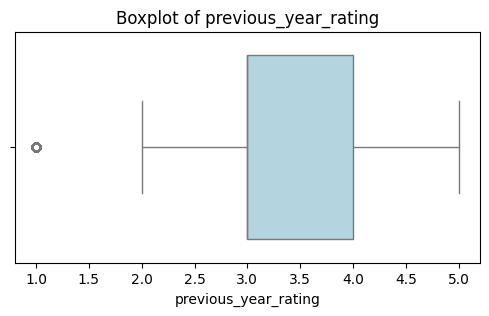

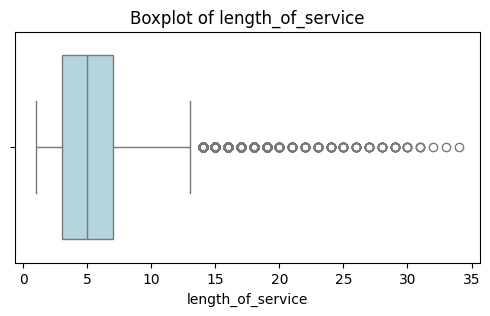

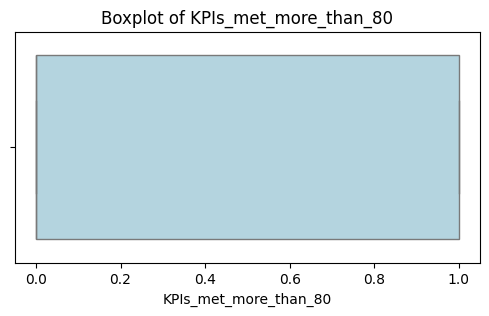

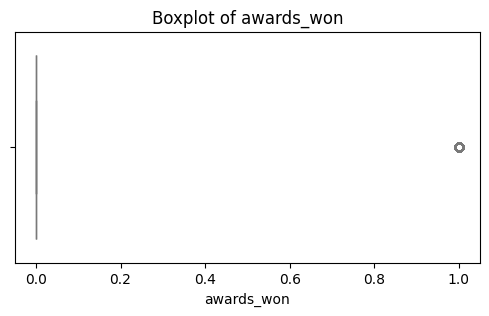

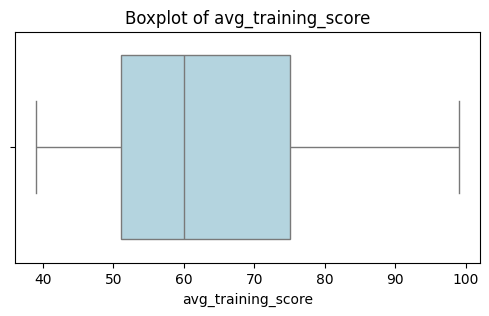

In [65]:
# Visual check for outliers in numerical columns
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f"Boxplot of {col}")
    plt.show()

In [66]:
# Handling outliers based on boxplot observations using IQR Capping method  
num_cols = ['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Apply capping
    df[col] = df[col].apply(lambda x: upper if x > upper else (lower if x < lower else x))

print("✅ Outliers handled successfully!")

✅ Outliers handled successfully!


# Phase 3: EDA & Data Quality

#### 🔹 Univariate Analysis

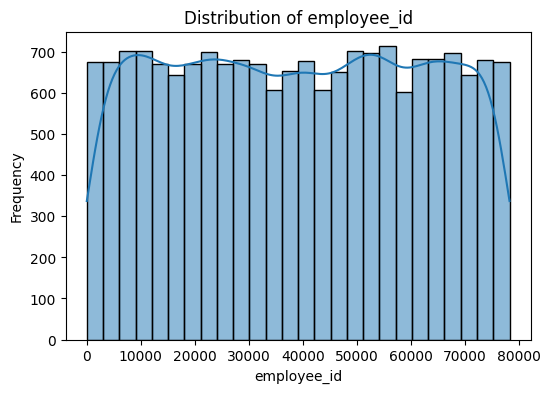

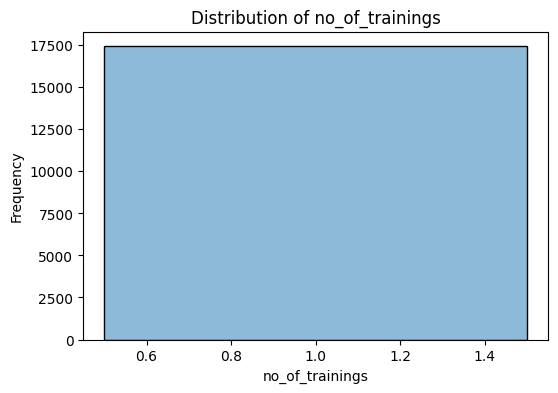

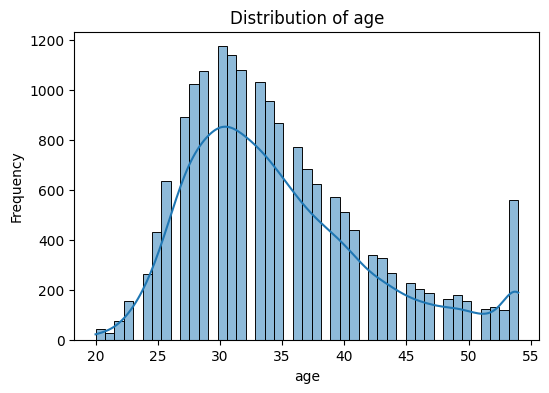

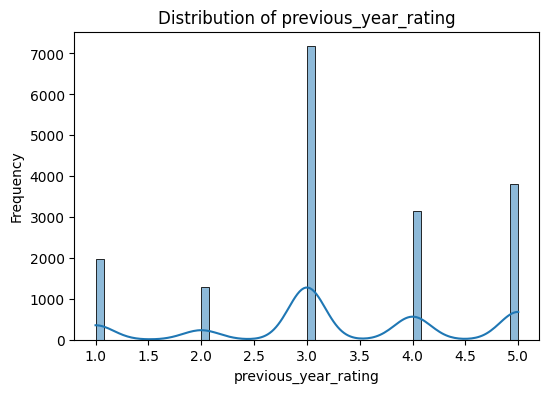

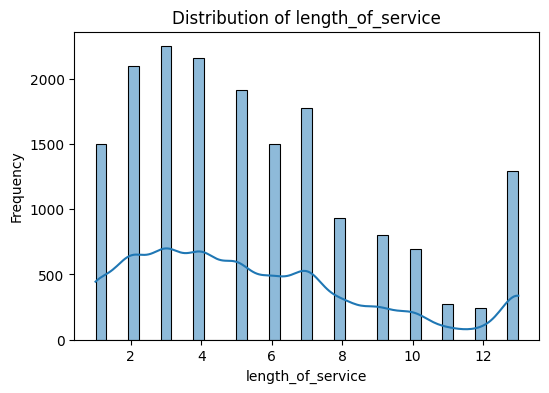

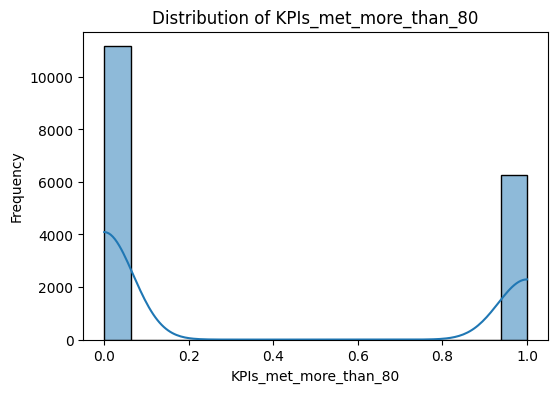

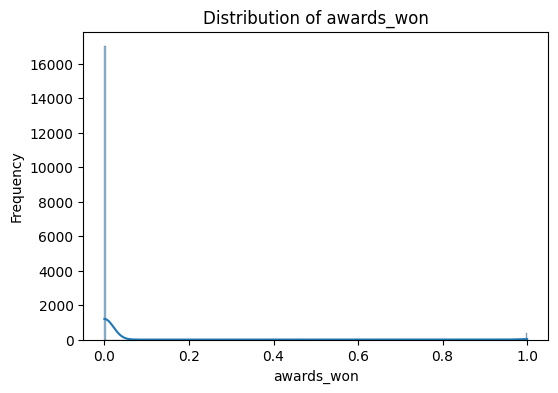

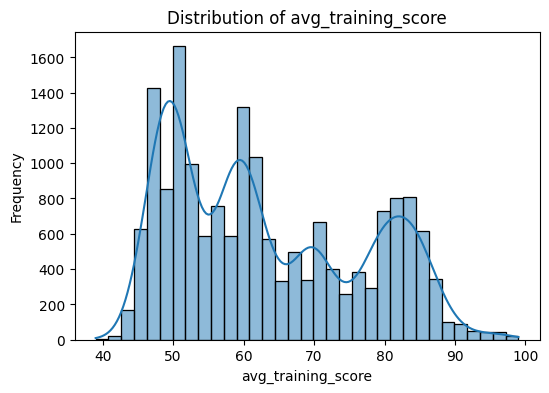

In [67]:
# Univariate analysis for numerical features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

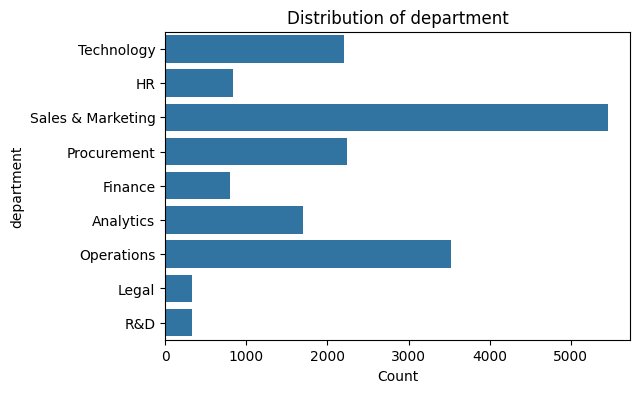

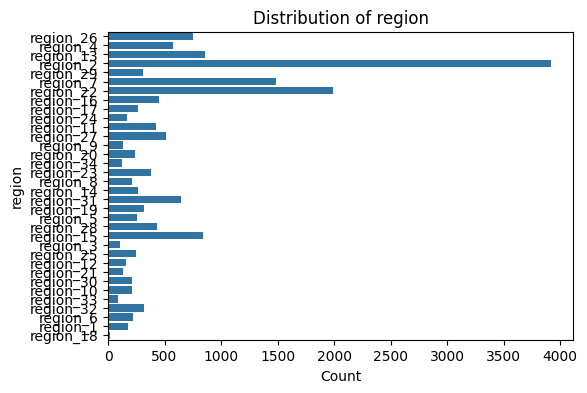

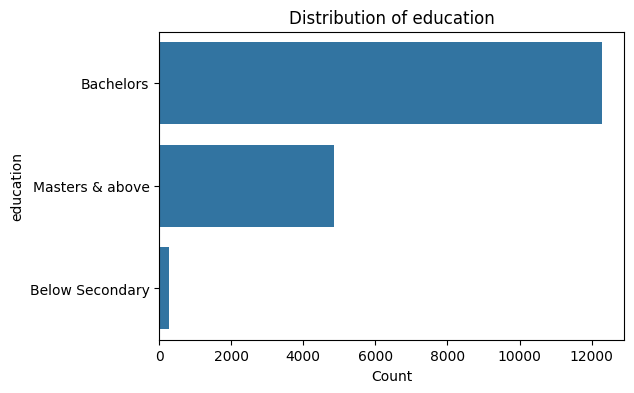

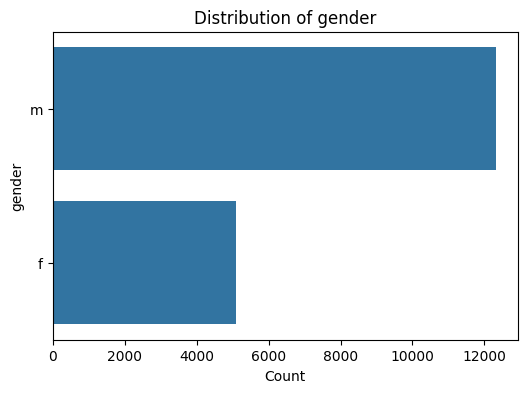

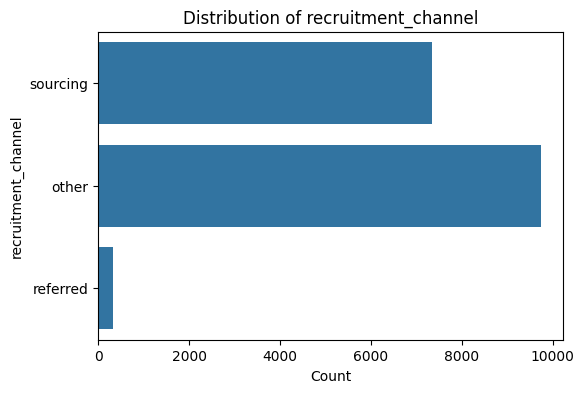

In [68]:
# Univariate analysis for categorical features
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()


#### 🔹 Bivariate Analysis

In [ ]:
# Numerical pairs plot 
sns.pairplot(df[num_cols])
plt.show()


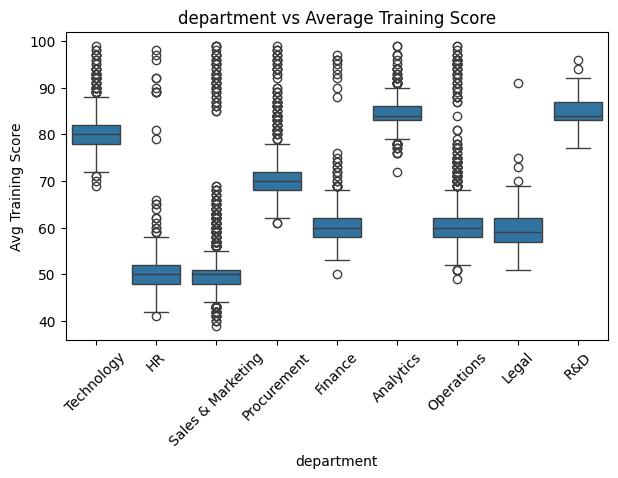

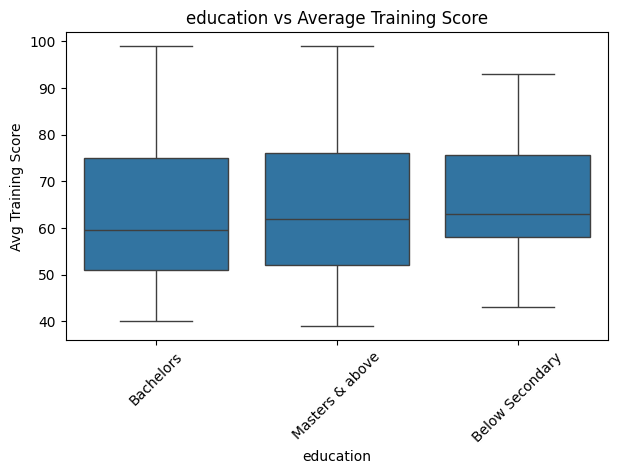

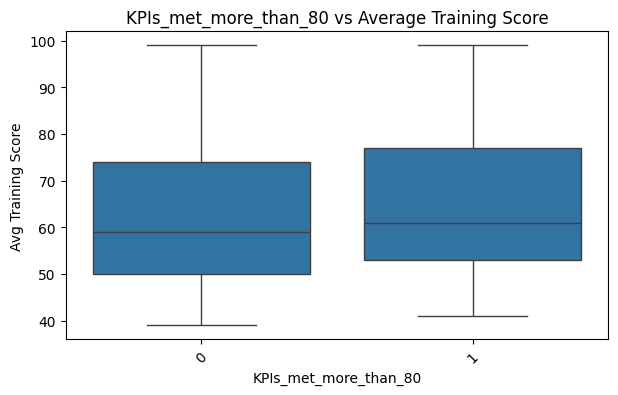

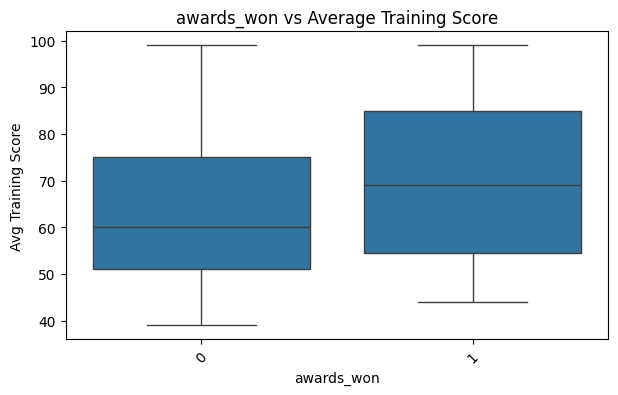

In [ ]:
# Categorical vs training score
categorical_features = ['department', 'education', 'KPIs_met_more_than_80', 'awards_won']

for col in categorical_features:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=col, y='avg_training_score', data=df)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Average Training Score")
    plt.xlabel(col)
    plt.ylabel("Avg Training Score")
    plt.show()


#### 🔹 Correlation + Heatmap

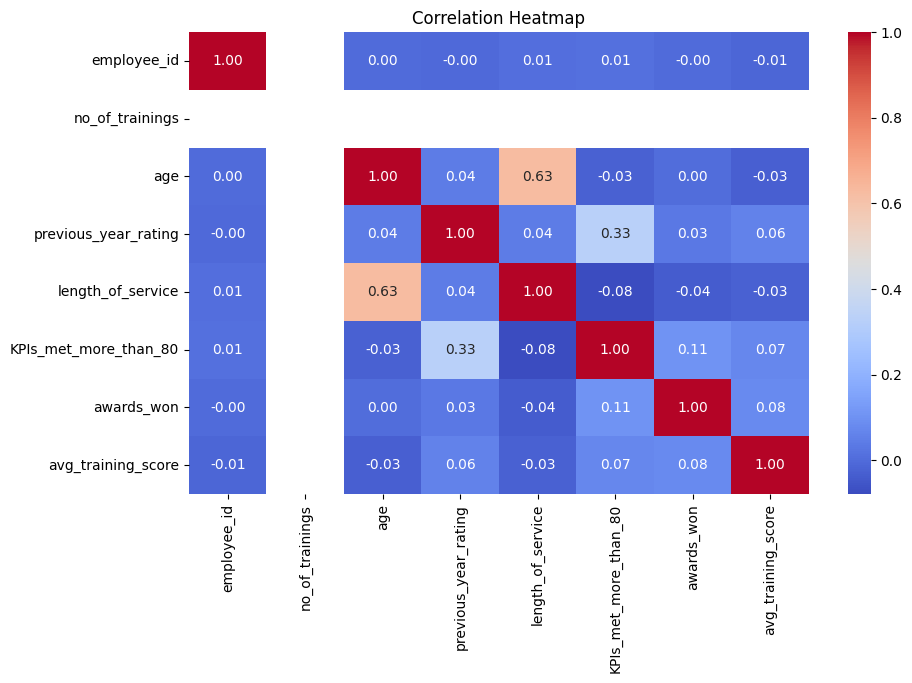

In [ ]:
# Correlation analysis for numerical features
corr_matrix = df[num_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### 🔹 VIF (Multicollinearity)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare numerical data for VIF calculation
X = df[num_cols]

# Calculate VIF for each numerical feature
vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])]

# Display VIF values
display(vif_df)


,Feature,VIF
0,employee_id,1.000480
1,no_of_trainings,57.500597
2,age,1.649774
3,previous_year_rating,1.129399
4,length_of_service,1.663531
5,KPIs_met_more_than_80,1.146649
6,awards_won,1.018503
7,avg_training_score,1.012737


## Exploratory Data Analysis (EDA) Summary

### Data Quality & Preprocessing
- Missing values in **education** and **previous_year_rating** were handled using mode and median.
- Duplicate records were removed.
- Outliers in **age**, **length_of_service**, **no_of_trainings**, and **avg_training_score** were treated using IQR capping.

###  Univariate Analysis Insights
- The majority of employees fall within the **25–40 age range**, indicating a relatively young workforce.
- Average training scores are generally centered around **moderate to high values**.
- Most employees did **not** receive awards and did **not** meet KPIs above 80%, suggesting improvement opportunities.

###  Bivariate Analysis Insights
- A positive relationship is observed between **previous_year_rating** and **average training score**, indicating consistency in performance.
- Employees who won awards tend to demonstrate **higher training scores**.
- Performance varies across **departments**, highlighting department-level differences.

###  Correlation Analysis
- A **moderate positive correlation** exists between *previous_year_rating* and *avg_training_score*.
- Length of service shows **weak correlation** with performance-related features, suggesting experience alone does not guarantee higher performance.

###  Multicollinearity Assessment (VIF)
- Variance Inflation Factor (VIF) values were within acceptable thresholds.
- No significant multicollinearity was detected, confirming the suitability of features for clustering.

### Conclusion
The EDA process provided a clear understanding of employee characteristics and performance patterns.  
The dataset is **clean, reliable, and well-prepared** for the next phase involving **feature engineering, scaling, and unsupervised learning techniques**.


# Phase 4: Data Preprocessing & Modeling


In [ ]:
# Copy to avoid touching original dataframe
df_model = df.copy()

# Drop obvious non-informative columns if any (IDs, names, etc.)
drop_cols = []  # # Add column names if needed
df_model.drop(columns=drop_cols, inplace=True, errors='ignore')

In [ ]:
# Preprocessing pipelines to scale numerical features and encode categorical features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [ ]:
# Fit & transform the data
X_processed = preprocessor.fit_transform(df_model)

print("Processed shape:", X_processed.shape)


Processed shape: (17415, 59)


## PCA for Dimensionality Reduction


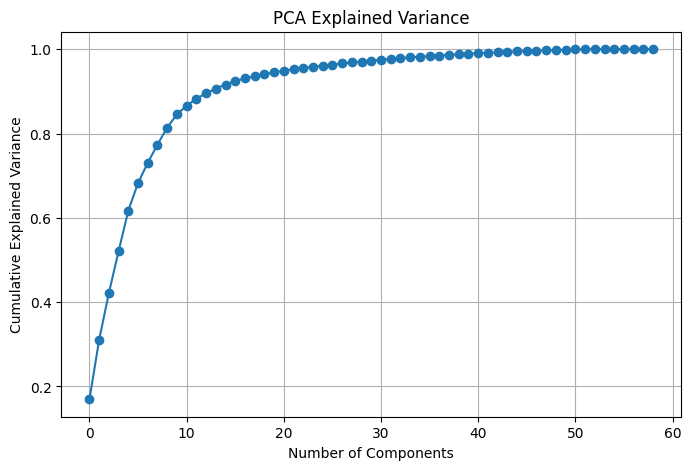

In [ ]:
# PCA - Step 1: Fit PCA to check explained variance
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_processed)

explained_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(explained_var, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()


In [ ]:
# PCA - Step 2: Apply PCA to reduce dimensions while keeping 90% variance
N_COMPONENTS = 0.9  # keep 90% variance

pca = PCA(n_components=N_COMPONENTS, random_state=42)
X_pca = pca.fit_transform(X_processed)

print("PCA shape:", X_pca.shape)


PCA shape: (17415, 14)


## Clustering Models & Evaluation


In [ ]:
# Evaluate clustering with multiple metrics
def evaluate_clustering(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels)
    }


  **K-Means Clustering**


In [ ]:
# K-Means Clustering - find best k using silhouette score
k_values = range(2, 11)
kmeans_results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    scores = evaluate_clustering(X_pca, labels)
    scores["k"] = k
    kmeans_results.append(scores)

kmeans_df = pd.DataFrame(kmeans_results)
kmeans_df


,Silhouette,Davies-Bouldin,Calinski-Harabasz,k
0,0.135090,2.439243,2490.815599,2
1,0.141351,2.158534,2458.895956,3
2,0.156926,1.743237,2794.915845,4
3,0.145122,1.713103,2634.533683,5
4,0.124253,1.761984,2372.216345,6
5,0.137127,1.866096,2232.622217,7
6,0.128749,1.844917,2088.977318,8
7,0.129296,1.918558,1952.876579,9
8,0.129036,1.913469,1863.943827,10


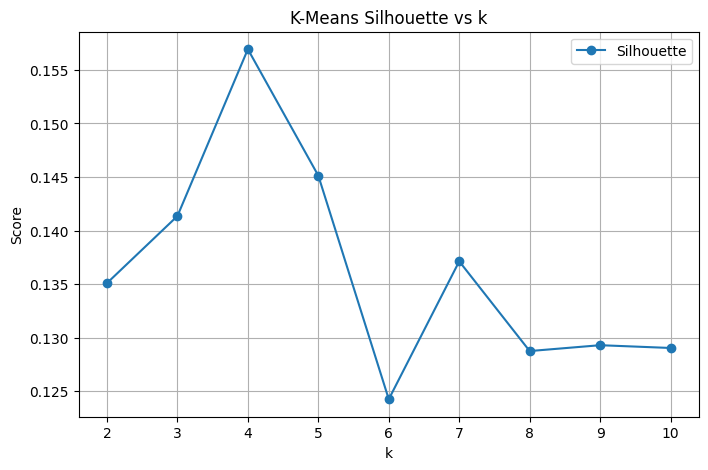

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(kmeans_df["k"], kmeans_df["Silhouette"], marker='o', label="Silhouette")
plt.xlabel("k")
plt.ylabel("Score")
plt.title("K-Means Silhouette vs k")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
best_k = kmeans_df.sort_values("Silhouette", ascending=False).iloc[0]["k"]
best_k = int(best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_pca)

kmeans_scores = evaluate_clustering(X_pca, kmeans_labels)
best_k, kmeans_scores


(4,
 {'Silhouette': np.float64(0.15692632636314563),
  'Davies-Bouldin': np.float64(1.7432370714609577),
  'Calinski-Harabasz': np.float64(2794.9158452393804)})

**Hierarchical Clustering**

In [ ]:
# Hierarchical Clustering - alternative clustering method
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = agg.fit_predict(X_pca)

agg_scores = evaluate_clustering(X_pca, agg_labels)
agg_scores


{'Silhouette': np.float64(0.13573856785039282),
 'Davies-Bouldin': np.float64(1.9230548235285765),
 'Calinski-Harabasz': np.float64(2393.250011445947)}

**DBSCAN Clustering**

In [ ]:
#DBSCAN Clustering - density-based method, removes noise points
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# remove noise for evaluation
mask = dbscan_labels != -1

dbscan_scores = evaluate_clustering(X_pca[mask], dbscan_labels[mask])
dbscan_scores


{'Silhouette': np.float64(0.14422690643866307),
 'Davies-Bouldin': np.float64(0.9029468688563428),
 'Calinski-Harabasz': np.float64(72.41545977662317)}

## Model Selection Summary


In [ ]:
# Compare clustering models and select the best
results = pd.DataFrame([
    {"Model": "KMeans", **kmeans_scores},
    {"Model": "Hierarchical", **agg_scores},
    {"Model": "DBSCAN", **dbscan_scores}
])

results

,Model,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.156926,1.743237,2794.915845
1,Hierarchical,0.135739,1.923055,2393.250011
2,DBSCAN,0.144227,0.902947,72.415460


## Save Final Model


In [ ]:
# Save final pipeline including preprocessing, PCA, and best clustering model

# go up one directory from Notebooks/
MODEL_DIR = os.path.join("..", "Model")

os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "final_clustering_model.pkl")

final_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("pca", pca),
    ("clustering", kmeans_final)
])

joblib.dump(final_pipeline, model_path)
print(f"Final model saved at: {model_path}")


Final model saved at: ..\Model\final_clustering_model.pkl
